# Inventory of functions used
A crude inventory of functions used. They're not very portable (a lot of hardcoded stuff), but if there's a need to we can refactor them to be more portable, and make more sense.

In [1]:
from herbie import Herbie, wgrib2, paint, FastHerbie
from herbie.toolbox import EasyMap, ccrs, pc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import math
import cv2
import requests
import json
import os
import sys
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
from datetime import timedelta

## HRRR

### `get_hrrr_surface_smoke_data(start_date, end_date, product)`
- Arguments:
    - `start_date` - start date, in the format: year-month-day-hour: aaaa-bb-cc-dd
    - `end_date` - the end date (inclusive), in the same format as `start_date`
    - `product` - regex of products you want to download
- Uses `herbie` to download HRRR-smoke's near-surface smoke field (called "MASSDEN").
    - Note that these are not forecasts; we download the hourly-assimilated data.
- Returns a list of Herbie objects.

In [2]:
# downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 169 hours
# not forecasts -- downloading actual hourly updated data
def get_hrrr_surface_smoke_data(start_date, end_date, product="MASSDEN"):
    dates = pd.date_range(start_date, end_date, freq="1h")
    FH = FastHerbie(dates, model="hrrr", fxx=[0])
    FH.download(product)
        
    return FH.objects

### `subregion_grib_files_to_numpy(herbie_data, extent, product)`
- Arguments:
    - `herbie_data`: list of herbie objects
    - `extent`: (longitude bottom, longitude top, latitude bottom, latitude top)
    - `product` - regex of products you want to download
- Validates downloads
- Subregions each grib file
- Converts the grib file into xarray, then to numpy
- Returns a numpy array of the grib data

In [3]:
def subregion_grib_files_to_numpy(herbie_data, extent, product="MASSDEN"):
    hrrr_subregion_list = []
    for H in herbie_data:
        # subregion grib files
        file = H.get_localFilePath(product)
        idx_file = wgrib2.create_inventory_file(file)
        subset_file = wgrib2.region(file, extent, name="la_region")

        # grib -> xarr -> numpy
        hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib", decode_timedelta=False)
        hrrr_subregion_list.append(np.flip(hrrr_xarr.mdens.to_numpy(), axis=0))

    return np.array(hrrr_subregion_list)

### `sliding_window_of(frames, sample_size, rows, cols, channels)`
- Arguments:
    - `frames`: a numpy array of frames
    - `sample_size`: the desired size of a sample
    - `rows`, `cols`: the row and column dimensions of the frame
    - `channels`: the number of channels in the sample
- Creates a sliding window of samples. e.g:
    - 5 frame sample = sample 1: 0-4 frames, sample 2: 1-5 frames, ..., sample n: \[n-1, n-1+4\] frames.
- Returns a numpy array containing the samples 

In [4]:
def sliding_window_of(frames, sample_size, rows, cols, channels):
    n_samples = len(frames) - sample_size
    samples = np.empty((n_samples, sample_size, rows, cols, channels))
    for i in range(n_samples):
        samples[i] = np.array([frames[j] for j in range(i, i + sample_size)])
        
    return samples

### `np_to_final_input(hrrr_subregion_np)`
- Arguments:
    - `hrrr_subregion_np`: a numpy array that contains the hrrr data that has been subject to a subregion.
    - `dim`: the desired dimensions of each frame
    - `sample_size`: the desired size of each sample (e.g. 5 implies each sample contains 5 frames)
- Interpolates
- Creates a channel axis
- Creates samples from frames using a sliding window
- Returns the final input for the convlstm, in the shape of (sample, frames, row, col, channel)

In [5]:
def np_to_final_input(hrrr_subregion_np, dim, sample_size):
    channels = 1
    n_frames = len(hrrr_subregion_np)
    frames = np.empty(shape=(n_frames, dim, dim, channels))

    # interpolate and add channel axis
    for i, frame in enumerate(hrrr_subregion_np):
        new_frame = cv2.resize(frame, (dim, dim))
        new_frame = np.reshape(new_frame, (dim, dim, channels))
        frames[i] = new_frame

    # create sample axis with a sliding window of frames
    complete_ds = sliding_window_of(frames, sample_size, dim, dim, channels)
    
    return complete_ds

## AirNow

### `get_airnow_data(start_date, end_date, lon_bottom, lat_bottom, lon_top, lat_top, airnow_api_key)`
- Arguments:
    - `start_date` and `end_date` in the format: year-month-day-hour: aaaa-bb-cc-dd, inclusive
    - `lon_bottom`, `lat_bottom`, `lon_top`, `lat_top`: bounding box
    - `airnow_api_key`: your AirNow API key
- Gets AirNow data
- Returns a list of station value dataframes.

In [6]:
def get_airnow_data(
    start_date, end_date, 
    lon_bottom, lat_bottom, lon_top, lat_top,
    airnow_api_key=None
):
    # get airnow data from the EPA
    if os.path.exists('data/airnow.json'):
        print("data/airnow.json already exists; skipping request...")
    else:
        # preprocess a few parameters
        date_start = pd.to_datetime(start_date).isoformat()[:13]
        date_end = pd.to_datetime(end_date).isoformat()[:13]
        bbox = f'{lon_bottom},{lat_bottom},{lon_top},{lat_top}'
        URL = "https://www.airnowapi.org/aq/data"
                
        # defining a params dict for the parameters to be sent to the API
        PARAMS = {
            'startDate':date_start,
            'endDate':date_end,
            'parameters':'PM25',
            'BBOX':bbox,
            'dataType':'B',
            'format':'application/json',
            'verbose':'0',
            'monitorType':'2',
            'includerawconcentrations':'1',
            'API_KEY':airnow_api_key
        }
        
        # sending get request and saving the response as response object
        response = requests.get(url = URL, params = PARAMS)
    
        # extracting data in json format, then download
        airnow_data = response.json()
        with open('data/airnow.json', 'w') as file:
            json.dump(airnow_data, file)
            print("JSON data saved to data/airnow.json")
        
    # open json file and convert to dataframe
    with open('data/airnow.json', 'r') as file:
        airnow_data = json.load(file)
    airnow_df = pd.json_normalize(airnow_data)

    # group station data by time
    list_df = [group for name, group in airnow_df.groupby('UTC')]
    
    return list_df

### `preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin)`
- Arguments:
    - `df`: dataframe containing the station data
    - `dim`: the desired dimensions of the grid
    - bounding box data
- Converts the station data into a grid format with the desired dimensions
- Returns the preprocessed frame

In [7]:
def preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin):
    latDist, lonDist = abs(latMax - latMin), abs(lonMax - lonMin)
    unInter = np.zeros((dim,dim))
    dfArr = np.array(df[['Latitude','Longitude','Value']])
    for i in range(dfArr.shape[0]):
        # Calculate x
        x = int(((latMax - dfArr[i,0]) / latDist) * dim)
        if x >= dim:
            x = dim - 1
        if x <= 0:
            x = 0
        # Calculate y
        y = dim - int(((lonMax + abs(dfArr[i,1])) / lonDist) * dim)
        if y >= dim:
            y = dim - 1
        if y <= 0:
            y = 0
        if dfArr[i,2] < 0:
            unInter[x,y] = 0
        else:
            unInter[x,y] = dfArr[i,2]
    return unInter

### `interpolated_frame(f, dim)`
- Arguments:
    - `f`: the frame to be interpolated
    - `dim`: the desired dimensions of the frame
- Returns the given frame, interpolated with IDW

In [8]:
def interpolate_frame(f, dim):
    i = 0
    interpolated = []
    count = 0
    idx = 0
    x_list = []
    y_list = []
    values = []
    for x in range(f.shape[0]):
        for y in range(f.shape[1]):
            if f[x,y] != 0:
                x_list.append(x)
                y_list.append(y)
                values.append(f[x,y])
    coords = list(zip(x_list,y_list))
    try:
        interp = NearestNDInterpolator(coords, values)
        X = np.arange(0,dim)
        Y = np.arange(0,dim)
        X, Y = np.meshgrid(X, Y)
        Z = interp(X, Y)
    except ValueError:
        Z = np.zeros((dim,dim))
    interpolated = Z
    count += 1
    i += 1
    interpolated = np.array(interpolated)
    return interpolated

## ETC

### `std_scale(data)`
- Arguments:
    - `data`, which is a numpy array of data
- Performs standard scaling

In [9]:
# we scale each sample relative to other samples
def std_scale(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return (data - mean) / stddev

# HRRR preprocessing

In [10]:
# define bounding box
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 40
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [11]:
# preprocessing pipeline
def get_hrrr_training_data(
    start_date, end_date,
    extent,
    dim, frames_per_sample
):    
    herbie_ds = get_hrrr_surface_smoke_data(start_date, end_date)
    np_subregion_ds = subregion_grib_files_to_numpy(herbie_ds, extent)
    X_hrrr = np_to_final_input(np_subregion_ds, dim, frames_per_sample)
    return X_hrrr
'''
X_hrrr = get_hrrr_training_data(start_date, end_date, extent, dim, frames_per_sample)
print(X_hrrr.shape)
'''

from libs.hrrrdata import HRRRData
HD = HRRRData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)
X_hrrr = HD.data
print(X_hrrr.shape)

║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ HRRR:sfc
║HERBIE╠ H

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

(164, 5, 40, 40, 1)


# AirNow preprocessing

In [12]:
# get data, process ground sites, interpolate, create samples
list_df = get_airnow_data(
    start_date, end_date,
    lon_bottom, lat_bottom, lon_top, lat_top
)
list_unInter = [preprocess_ground_sites(df, dim, lat_top, lat_bottom, lon_top, lon_bottom) for df in list_df]
list_inter = [interpolate_frame(unInter, dim) for unInter in list_unInter]
frames = np.expand_dims(np.array(list_inter), axis=-1)
X_airnow = sliding_window_of(frames, frames_per_sample, dim, dim, 1)

print(X_airnow.shape)

data/airnow.json already exists; skipping request...
(164, 5, 40, 40, 1)


# Joint preprocessing
- Create Y dataset
- Combine X datasets into 1 with 2 channels
- Split into train/test sets
- Scale train/test sets independently, and by channel

In [13]:
# generate labels for airnow data
airnow_sens_loc = {
    'Reseda': (5, 4),
    'North Holywood (sic)': (6, 14),
    'Los Angeles - N. Main Street': (13, 22),
    'Compton': (22, 23),
    'Long Beach Signal Hill': (28, 25),
    'Anaheim': (26, 38),
}

n_samples = len(X_airnow)
n_sensors = len(airnow_sens_loc)
Y = np.empty((n_samples, n_sensors))

# if we have 5 frames per sample, the goal is the predict the 6th frame
# this means y should be offset by 5 relative to x
for frame in range(len(Y)):
    for sensor, loc in enumerate(airnow_sens_loc):
        x, y = airnow_sens_loc[loc]
        Y[frame][sensor] = list_unInter[frame+frames_per_sample][x][y]
        
print(Y.shape)

(164, 6)


In [15]:
# for now we'll just scale first, as per the pwwb nb
X_hrrr = std_scale(X_hrrr)
X_airnow = std_scale(X_airnow)

# combine by adding a new channel
X = np.concatenate([X_hrrr, X_airnow], axis=-1)
print("HRRR and AirNow, combined by channel:", X.shape)

# perform a simple split into training and validation sets
split_idx = int(X.shape[0] * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

print("X_train/test dataset shape:", X_train.shape, X_test.shape)
print("y_train/test dataset shape:", y_train.shape, y_test.shape)

HRRR and AirNow, combined by channel: (164, 5, 40, 40, 2)
X_train/test dataset shape: (123, 5, 40, 40, 2) (41, 5, 40, 40, 2)
y_train/test dataset shape: (123, 6) (41, 6)


# Final input viz

Displaying frames for example 102.


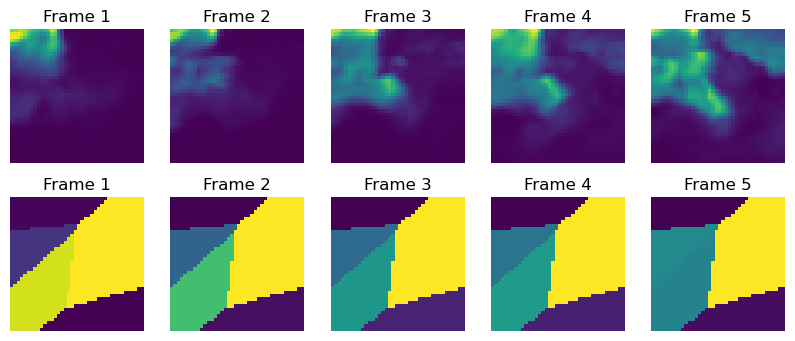

Target:  [ 2.  11.1 11.2 19.7  0.   4.8]


In [16]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

# Model

In [17]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-07 14:01:00.752068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 14:01:00.814104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 2))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,537 (463.04 KB)

 Trainable params: 118,537 (463.04 KB)

 Non-trainable params: 0 (0.00 B)

# Train and test

In [19]:
seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 12.5436
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 7.5108
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 6.4650
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - loss: 5.8831
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 5.6133
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 5.1213
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 4.9580
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 5.2250
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 4.8486
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 4.6099
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 4.0687
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 4.3965
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 4.5095
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 5.4453
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 3.8517
Epo

In [20]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

(41, 6) (41, 6)


In [21]:
from skimage.metrics import mean_squared_error as mse

def mserr(y_pred, y_test):
    ep = 0.45
    return ep + 0.002*mse(y_pred, y_test)

def rmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test))

def nrmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test)) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(airnow_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 0.70
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 7.27%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 0.69
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 5.76%

Frame 2 (Hour 2) All Locations - Raw RMSE: 0.69
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 5.95%

Frame 3 (Hour 3) All Locations - Raw RMSE: 0.70
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 5.79%

Frame 4 (Hour 4) All Locations - Raw RMSE: 0.70
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 5.65%

Frame 5 (Hour 5) All Locations - Raw

# Thoughts
- idk what `mserr` is doing, what's with this extra computation doing here? what not just basic `mse`?
- strictly speaking, I don't think we're "using the previous 5 frames to predict 5 future frames". We're using the 5 previous frames to predict the future values of the 6 stations in the next hour. It's not like a classic seq2seq model where 5 frames predict the next frame, then the next prediction uses 4+1 frames to predict the frame after, etc. To do that, we'll have to do next frame prediction (create a new hrrr frame and interpolated airnow sensor frame?

# RMSE results visualization


Visualizing model predictions vs actual values...


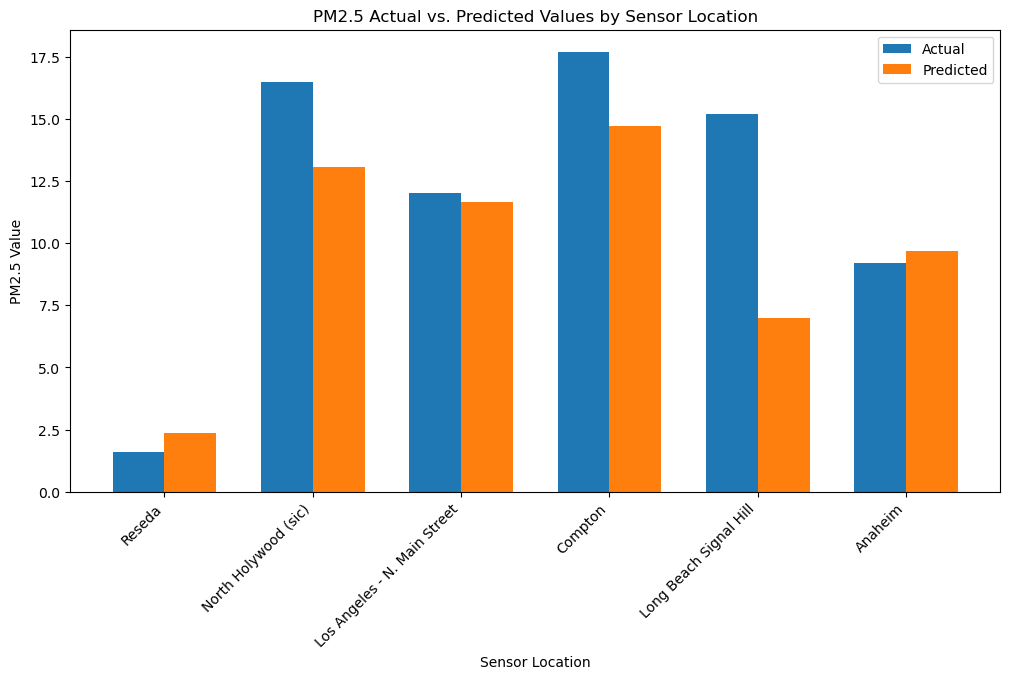

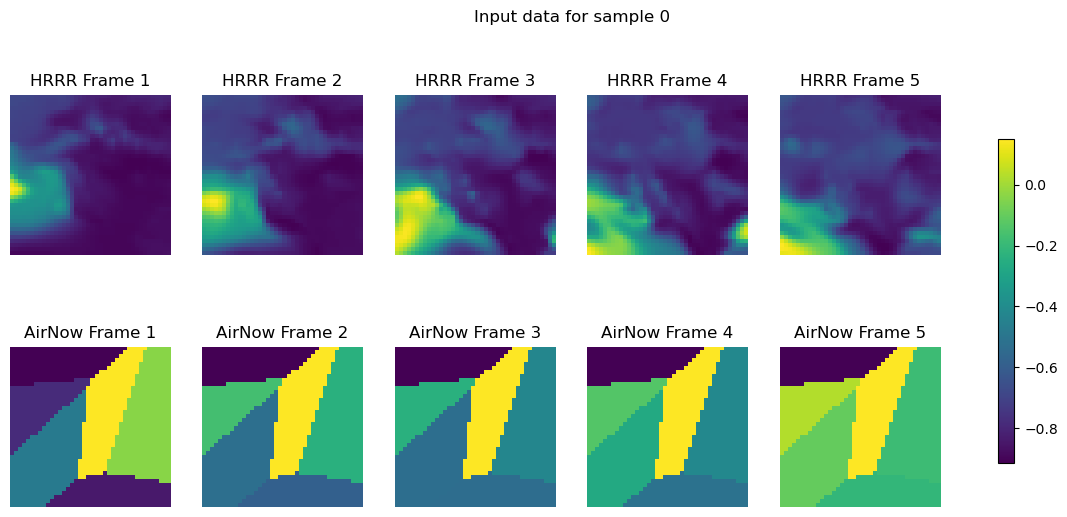

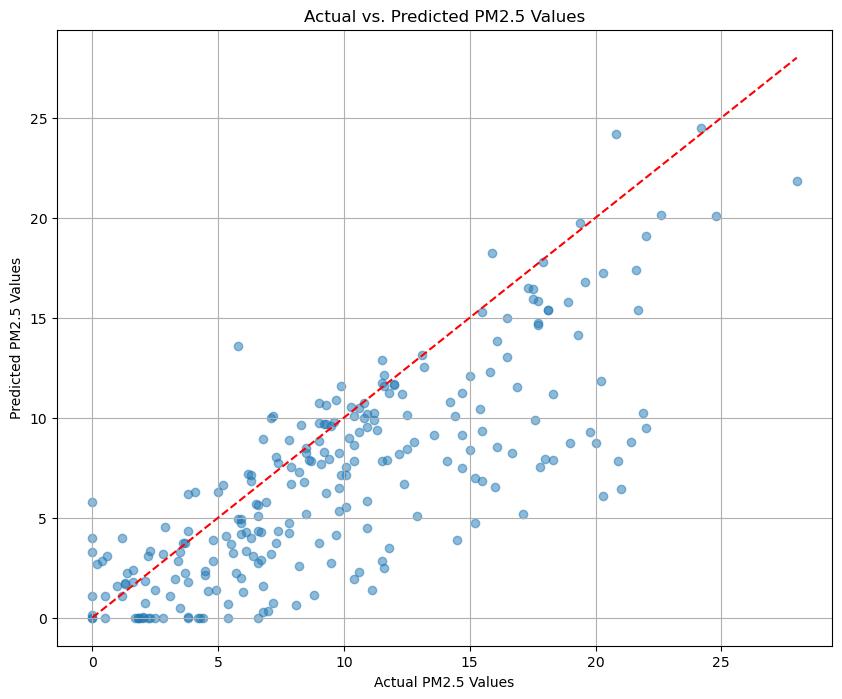

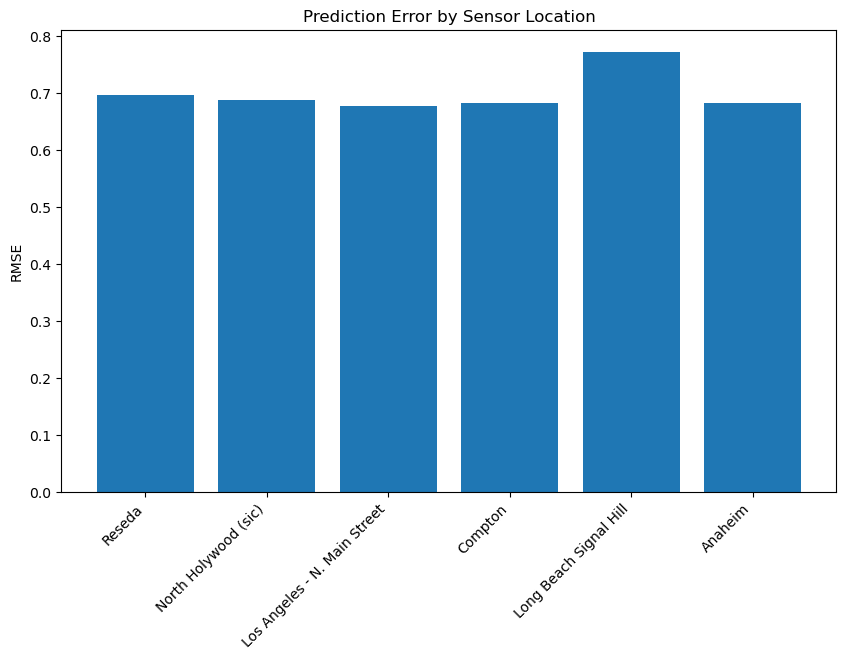

In [24]:
print("\nVisualizing model predictions vs actual values...")

# Choose the first test sample for consistent visualizations
sample_idx = 0

# Create a bar chart comparing predicted vs actual values for each sensor
fig, ax = plt.subplots(figsize=(12, 6))
sensor_names = list(airnow_sens_loc.keys())
x = np.arange(len(sensor_names))
width = 0.35

true_vals = y_test[sample_idx]
pred_vals = y_pred[sample_idx]

rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
ax.set_ylabel('PM2.5 Value')
ax.set_xlabel('Sensor Location')
ax.set_xticks(x)
ax.set_xticklabels(sensor_names, rotation=45, ha='right')
ax.legend()

#plt.tight_layout()
plt.show()

# Visualize input data for a specific sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot hrrr data (channel 0)
for idx, ax in enumerate(axes[0]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 0]), cmap='viridis')
    ax.set_title(f"HRRR Frame {idx + 1}")
    ax.axis("off")

# Plot AirNow data (channel 1)
for idx, ax in enumerate(axes[1]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 1]), cmap='viridis')
    ax.set_title(f"AirNow Frame {idx + 1}")
    ax.axis("off")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
plt.suptitle(f'Input data for sample {sample_idx}')
#plt.tight_layout()
plt.show()

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PM2.5 Values')
plt.ylabel('Predicted PM2.5 Values')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Compute error metrics for each sensor
error_by_sensor = []
for i, sensor in enumerate(sensor_names):
    error = rmse(y_pred[:, i], y_test[:, i])
    error_by_sensor.append(error)

# Create bar chart of errors by sensor
plt.figure(figsize=(10, 6))
plt.bar(sensor_names, error_by_sensor)
plt.ylabel('RMSE')
plt.title('Prediction Error by Sensor Location')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()